<a href="https://colab.research.google.com/github/kanri3/deep_learning_day1_day2/blob/main/1_3_stochastic_gradient_descent_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
# import sys
# sys.path.append('/content/drive/My Drive/DNN_code')

# importと関数定義

In [ ]:
# import numpy as np
# from common import functions
# import matplotlib.pyplot as plt

# def print_vec(text, vec):
#     print("*** " + text + " ***")
#     print(vec)
#     #print("shape: " + str(x.shape))
#     print("")

In [ ]:
import numpy as np
# from common import functions
import matplotlib.pyplot as plt

def print_vec(text, vec):
    print("*** " + text + " ***")
    np.set_printoptions(precision=5)
    print(vec)
    print("shape:", vec.shape)
    #print("shape: " + str(x.shape))
    # print("")

# ReLU関数
def relu(x):
    return np.maximum(0, x)
# 中間層の活性化関数
# シグモイド関数（ロジスティック関数）
def sigmoid(x):
    return 1/(1 + np.exp(-x))
# 出力層の活性化関数
# ソフトマックス関数
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))
# クロスエントロピー
def cross_entropy_error(d, y):
    if y.ndim == 1:
        d = d.reshape(1, d.size)
        y = y.reshape(1, y.size)
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    # One-hotベクトルとは、(0,1,0,0,0,0) の様に、1つの成分が1で残りの成分が全て0であるベクトルのこと
    if d.size == y.size:
        # NumPyのargmax関数は、多次元配列の中の最大値の要素を持つインデックスを返す関数
        d = d.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size
# 誤差関数
# 平均二乗誤差
def mean_squared_error(d, y):
    return np.mean(np.square(d - y)) / 2
# シグモイドとクロスエントロピーの複合導関数
def d_sigmoid_with_loss(d, y):
    return y - d
# ReLU関数の導関数
def d_relu(x):
    return np.where( x > 0, 1, 0)
# 平均二乗誤差の導関数
def d_mean_squared_error(d, y):
    if type(d) == np.ndarray:
        batch_size = d.shape[0]
        dx = (y - d)/batch_size
    else:
        dx = y - d
    return dx
# 活性化関数の導関数
# シグモイド関数（ロジスティック関数）の導関数
def d_sigmoid(x):
    dx = (1.0 - sigmoid(x)) * sigmoid(x)
    return dx

# 確率勾配降下法

In [ ]:
# サンプルとする関数
#yの値を予想するAI

def f(x):
    y = 3 * x[0] + 2 * x[1]
    return y

# 初期設定
def init_network():
    # print("##### ネットワークの初期化 #####")
    network = {}
    nodesNum = 10
    # np.random.randn()は、平均0、分散1（標準偏差1）の正規分布（標準正規分布）に従う乱数を返す。
    network['W1'] = np.random.randn(2, nodesNum)
    network['W2'] = np.random.randn(nodesNum)
    network['b1'] = np.random.randn(nodesNum)
    network['b2'] = np.random.randn(nodesNum)

    print_vec("重み1", network['W1'])
    print_vec("重み2", network['W2'])
    print_vec("バイアス1", network['b1'])
    print_vec("バイアス2", network['b2'])

    return network

# 順伝播
def forward(network, x):
    # print("##### 順伝播開始 #####")
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']
    u1 = x @ W1 + b1
    # u1 = np.dot(x, W1) + b1
    z1 = relu(u1)
    # z1 = functions.relu(u1)
    ## 試してみよう
    #z1 = functions.sigmoid(u1)
    u2 = z1 @ W2 + b2
    # u2 = np.dot(z1, W2) + b2
    y = u2

    # print_vec("総入力1", u1)
    # print_vec("中間層出力1", z1)
    # print_vec("総入力2", u2)
    # print_vec("出力1", y)
    # print("出力合計: " + str(np.sum(y)))    
    return z1, y

# 誤差逆伝播
def backward(x, d, z1, y):
    # print("\n##### 誤差逆伝播開始 #####")    

    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']

    # 出力層でのデルタ
    delta2 = d_mean_squared_error(d, y)
    # delta2 = functions.d_mean_squared_error(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = z1.T @ delta2
    # grad['W2'] = np.dot(z1.T, delta2)

    # 中間層でのデルタ
    delta1 = (delta2 @ W2.T) * d_relu(z1)
    #delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)

    # 試してみよう
    # delta1 = (delta2 @ W2.T) * d_sigmoid(z1)
    # delta1 = np.dot(delta2, W2.T) * functions.d_sigmoid(z1)

    delta1 = delta1[np.newaxis, :]
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    x = x[np.newaxis, :]
    # W1の勾配
    grad['W1'] = x.T @ delta1
    # grad['W1'] = np.dot(x.T, delta1)
    
    # print_vec("偏微分_重み1", grad["W1"])
    # print_vec("偏微分_重み2", grad["W2"])
    # print_vec("偏微分_バイアス1", grad["b1"])
    # print_vec("偏微分_バイアス2", grad["b2"])
    return grad

data_sets[:10]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(data_sets): 100000
data_sets[ 0 ]['x'] [0.80755 0.32757]
data_sets[ 1 ]['x'] [0.70992 0.28724]
data_sets[ 2 ]['x'] [0.12127 0.38502]
*** 重み1 ***
[[-0.33741 -0.39853 -0.13839  1.74501 -0.72265 -1.09869  0.96114 -0.74025
  -2.01102  0.63868]
 [ 0.66398  2.6546   0.46626  0.2911   0.80051  0.66062  0.68597 -0.48273
  -0.25068 -0.98781]]
shape: (2, 10)
*** 重み2 ***
[-1.93939  0.94112  0.51675  0.89005 -1.33609  0.45778 -1.24149  1.20708
  1.04168 -0.5448 ]
shape: (10,)
*** バイアス1 ***
[ 0.40767  0.46398  0.71433  1.05378  0.98307 -0.41775  1.51657 -0.82758
  0.35186  1.25124]
shape: (10,)
*** バイアス2 ***
[-0.65771 -0.52929  0.90651  1.90941 -1.38106  0.39205  0.99249  1.15142
  0.41644 -0.08413]
shape: (10,)
##### 結果表示 #####


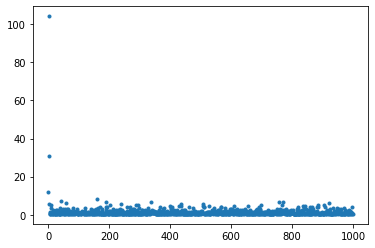

In [ ]:
# サンプルデータを作成
data_sets_size = 100000
data_sets = [0 for i in range(data_sets_size)]
print("data_sets[:10]:", data_sets[:10])
print("len(data_sets):", len(data_sets))

for i in range(data_sets_size):
    data_sets[i] = {}
    # ランダムな値を設定
    data_sets[i]['x'] = np.random.rand(2)
    if i<3 :
      print("data_sets[",i,"]['x']", data_sets[i]['x'])
    
    ## 試してみよう_入力値の設定
    # data_sets[i]['x'] = np.random.rand(2) * 10 -5 # -5〜5のランダム数値
    
    # 目標出力を設定
    data_sets[i]['d'] = f(data_sets[i]['x'])
    
losses = []
# 学習率
learning_rate = 0.07

# 抽出数
epoch = 1000

# パラメータの初期化
network = init_network()
# データのランダム抽出
random_datasets = np.random.choice(data_sets, epoch)

# 勾配降下の繰り返し
for dataset in random_datasets:
    x, d = dataset['x'], dataset['d']
    z1, y = forward(network, x)
    grad = backward(x, d, z1, y)
    # パラメータに勾配適用
    for key in ('W1', 'W2', 'b1', 'b2'):
        network[key]  -= learning_rate * grad[key]

    # 誤差
    loss = mean_squared_error(d, y)
    # loss = functions.mean_squared_error(d, y)
    losses.append(loss)

print("##### 結果表示 #####")    
lists = range(epoch)
plt.plot(lists, losses, '.')
# グラフの表示
plt.show()